### Image classification with rotation

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import optimizers
from keras import layers
from keras import models
from keras import utils
from keras import callbacks

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
data_dir = "./Bone Break Classification/"

# Load data set
full_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    subset=None,  # Load entire dataset
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=37
)

Found 1129 files belonging to 10 classes.


In [10]:
class_names = full_data.class_names
class_names_dict = {
    0: 'Avulsion fracture', 
    1: 'Comminuted fracture', 
    2: 'Fracture Dislocation',
    3: 'Greenstick fracture',
    4: 'Hairline Fracture',
    5: 'Impacted fracture',
    6: 'Longitudinal fracture',
    7: 'Oblique fracture',
    8: 'Pathological fracture',
    9: 'Spiral Fracture'
}

#### Modified preprocess function to randomly rotate

In [11]:
# Data preprocessing
def preprocess(img):
      
    # Randomly select rotation angle with 25% probability for each angle
    rotations = [0, 90, 180, 270]
    rotation_angle = np.random.choice(rotations)
    
    # Rotate the image
    img = tf.image.rot90(img, k=rotation_angle//90)

    img = tf.cast(img, "float32") / 255.0
    
    return img

full_dataset = full_data.map(lambda x, y: (preprocess(x), y))

In [12]:
# Get train data and labels
x_full = []
y_full = []

for images, labels in full_dataset:
    # Append train data to x_train
    x_full.append(images.numpy())
    
    # Append labels to y_train
    y_full.append(labels.numpy())
    
# Concatenate all the batches to get the full list
x_full = np.concatenate(x_full, axis=0)
y_full = np.concatenate(y_full, axis=0)

In [13]:
# Break full data into train and test

# Define the ratio for splitting (e.g., 90% training, 10% testing)
train_ratio = 0.9

# Calculate the number of samples for training
num_train_samples = int(len(x_full) * train_ratio)

# Shuffle indices to ensure randomization
indices = np.arange(len(x_full))
np.random.shuffle(indices)

# Split the indices into training and testing indices
train_indices = indices[:num_train_samples]
test_indices = indices[num_train_samples:]

# Split the data and labels using the indices
x_train, y_train = x_full[train_indices], y_full[train_indices]
x_test, y_test = x_full[test_indices], y_full[test_indices]


In [14]:
# One-hot encode the train, val data

NUM_CLASSES = len(class_names)

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)

In [15]:
input_layer = layers.Input(shape=(256, 256, 3))

# Convolutional base
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten layer
x = layers.Flatten()(x)

# Dense layers
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Output layer
output_layer = layers.Dense(units=10, activation='softmax')(x)

# Create model
model = models.Model(input_layer, output_layer)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       738

In [16]:
opt = optimizers.Adam(learning_rate=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [17]:
history = model.fit(
    x_train,
    y_train,
    shuffle=True,
    batch_size=32,
    epochs=10,
    validation_data=(x_test, y_test)
)

Epoch 1/10


32/32 [==============================] - 37s 1s/step - loss: 2.3285 - accuracy: 0.1211 - val_loss: 2.2749 - val_accuracy: 0.1327
Epoch 2/10
32/32 [==============================] - 34s 1s/step - loss: 2.2572 - accuracy: 0.1673 - val_loss: 2.2442 - val_accuracy: 0.2035
Epoch 3/10
32/32 [==============================] - 33s 1s/step - loss: 2.1394 - accuracy: 0.2441 - val_loss: 2.1660 - val_accuracy: 0.2124
Epoch 4/10
32/32 [==============================] - 33s 1s/step - loss: 1.9197 - accuracy: 0.3219 - val_loss: 2.2339 - val_accuracy: 0.2478
Epoch 5/10
32/32 [==============================] - 34s 1s/step - loss: 1.6575 - accuracy: 0.4065 - val_loss: 2.3462 - val_accuracy: 0.2566
Epoch 6/10
32/32 [==============================] - 33s 1s/step - loss: 1.3440 - accuracy: 0.5512 - val_loss: 2.3678 - val_accuracy: 0.3451
Epoch 7/10
32/32 [==============================] - 33s 1s/step - loss: 1.0250 - accuracy: 0.6831 - val_loss: 2.5188 - val_accuracy: 0.2832
Epoch 8/10
32/32 [

In [18]:
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["val_accuracy"]

In [19]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 1s 214ms/step - loss: 3.4158 - accuracy: 0.3717


[3.4158129692077637, 0.37168142199516296]

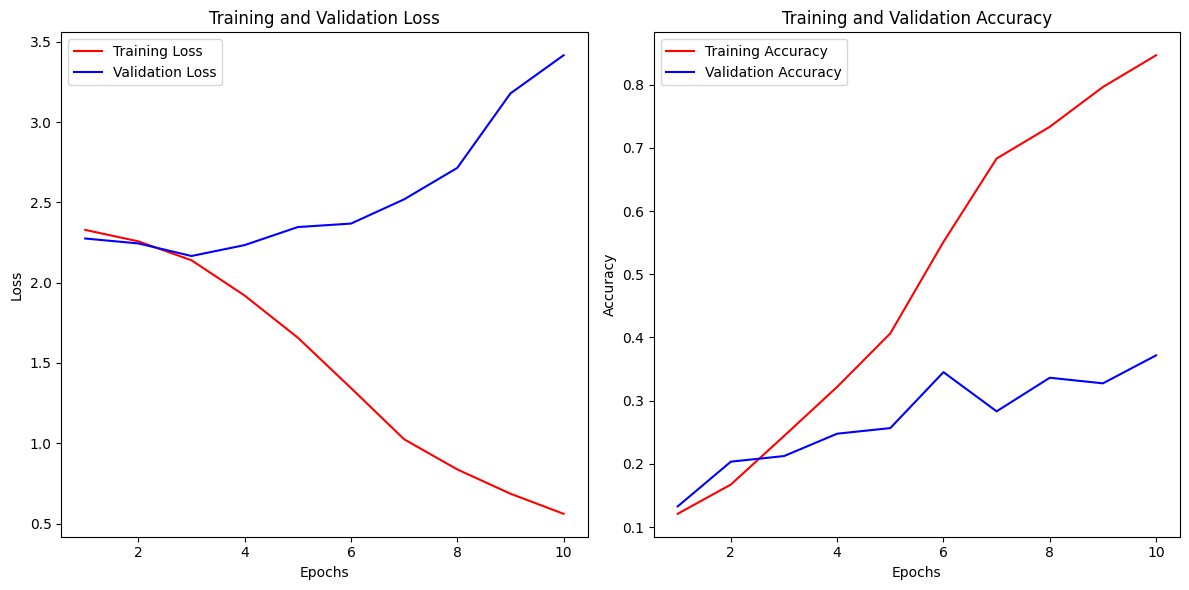

In [20]:
# Plot learning curve

epochs= range(1,11)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'b-', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracy, 'r-', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b-', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

It is possible that I just got lucky, but it seems random rotations help slightly in adressing the earlier overfitting issue. The accuracy has increased by about 3% on the test set and gone down about 10% on the training set.